
**Active Learning Model for Underwater Fish Species Identifications**
---



**Author : M M Nabi**\
**Email: mm.nabi@wku.edu**

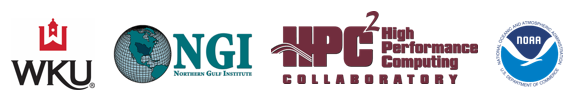

**The National Marine Fisheries Service (NMFS), part of NOAA, uses Artificial Intelligence (AI) and Machine Learning (ML) to automate image processing from video surveys, providing key data for managing ocean resources. A large reef fish video dataset, GFISHERD24, was collected from the Gulf of Mexico, spanning Brownsville, TX, to the Dry Tortugas, FL, at depths of 15 to 200 meters. It includes 200,000 image samples. An advanced AI model, called active learning, has been developed to detect and classify fish, significantly reducing data annotation costs**

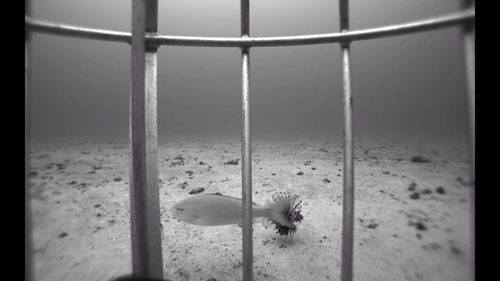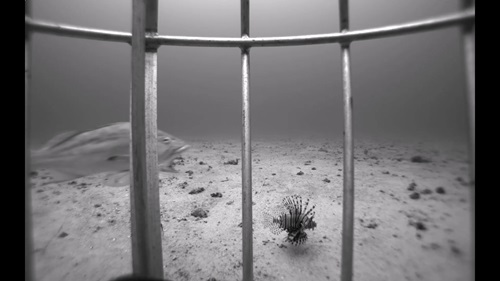

**Figure: Sample frames from GFISHERD24 dataset**

In this notebook, we will demostrate our active learning tranining process, train a sample model in Google Colab and generate prediction from the model.

**Setting Up Datasets**
The dataset should be in the Pascal VOC dataset format. The fish dataset comprises 149 classes. You can change the number of classes from the config file. The PASCAL VOC folder structure is like this:


```
VOC_ROOT
|__ VOC2007
    |_ JPEGImages
    |_ Annotations
    |_ ImageSets

```



**We need to connect the google drive with google colab to access the models and scripts. It may require google authentication to access your drive. We are utilizing T4 GPU runtime in google colab. Make sure to check and update your runtime.**

In [ ]:
# Connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

**Need to connect orginal directory to access code and models**

In [ ]:
cd /content/drive/MyDrive/Google_colab/AL-MDN


/content/drive/MyDrive/Google_colab/AL-MDN


**This part is loading necessary packagees such as torch, common python packages. We are also importing some funtion such as `build_ssd_gmm`, `VOC_CLASSES` from our Active learning model**

In [ ]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss_GMM
from ssd_gmm import build_ssd_gmm
from utils.test_voc import *
from active_learning_loop import *
import os
import sys
import time
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data
import numpy as np
import argparse
import math
import random
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
from subset_sequential_sampler import SubsetSequentialSampler

import warnings
warnings.filterwarnings("ignore")


random.seed(314) # need to change manually
torch.manual_seed(314) # need to change manually

**This part is to provide important argument for the Active learning model. We can select number of CPUs, GPUs, batch size, learning rate, etc. We also need to supply initial training weights (`vgg16_reducefc.pth`) of the model**

In [ ]:
class Args:
    dataset = 'VOC'
    voc_root = VOC_ROOT
    coco_root = COCO_ROOT
    basenet = 'vgg16_reducedfc.pth'
    batch_size = 4
    resume = None
    start_iter = 0
    num_workers = 1
    cuda = True
    lr = 1e-3
    momentum = 0.9
    weight_decay = 5e-4
    gamma = 0.5
    save_folder = 'weights/'
    eval_save_folder = 'eval/'
    use_cuda = True
    id = 1
    top_k = 5
    confidence_threshold = 0.01
args = Args()

**This code is mostly design to run in a GPU machine. For efficiency, please utlize GPU.**

In [ ]:
if args.dataset == 'VOC':
    cfg = voc300_active
else:
    cfg = coco300_active

if torch.cuda.is_available():
    if args.cuda:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    if not args.cuda:
        print("WARNING: It looks like you have a CUDA device, but aren't " +
              "using CUDA.\nRun with --cuda for optimal training speed.")
        torch.set_default_tensor_type('torch.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

if not os.path.exists(args.save_folder):
    os.mkdir(args.save_folder)
if not os.path.exists(args.eval_save_folder):
    os.mkdir(args.eval_save_folder)

*** This part is loading necessary training data specialy labelled and unlabelled data for the supervised and active learning cycle***

In [ ]:
def create_loaders():
    num_train_images = cfg['num_total_images']
    indices = list(range(num_train_images))
    random.shuffle(indices)
    labeled_set = indices[:cfg['num_initial_labeled_set']]
    unlabeled_set = indices[cfg['num_initial_labeled_set']:]

    if cfg['name'] == 'VOC':
        supervised_dataset = VOCDetection(root=args.voc_root, transform=SSDAugmentation(cfg['min_dim'], MEANS))
        unsupervised_dataset = VOCDetection(args.voc_root, [('2007', 'trainval')],
                                            BaseTransform(300, MEANS),
                                            VOCAnnotationTransform())
    else:
        supervised_dataset = COCODetection(root=args.coco_root, transform=SSDAugmentation(cfg['min_dim'], MEANS))
        unsupervised_dataset = COCODetection(args.coco_root,
                                             transform=BaseTransform(300, MEANS))

    supervised_data_loader = data.DataLoader(supervised_dataset, batch_size=args.batch_size,
                                             num_workers=args.num_workers,
                                             sampler=SubsetRandomSampler(labeled_set),
                                             collate_fn=detection_collate,
                                             pin_memory=True)

    unsupervised_data_loader = data.DataLoader(unsupervised_dataset, batch_size=1,
                                               num_workers=args.num_workers,
                                               sampler=SubsetSequentialSampler(unlabeled_set),
                                               collate_fn=detection_collate,
                                               pin_memory=True)
    return supervised_dataset, supervised_data_loader, unsupervised_dataset, unsupervised_data_loader, indices, labeled_set, unlabeled_set


**This part of the code is reponsible to load different sets of data such as supervised and unsupervised data. We provided the initial number of supervised dataset.**

In [ ]:
def change_loaders(
    supervised_dataset,
    unsupervised_dataset,
    labeled_set,
    unlabeled_set,
):
    supervised_data_loader = data.DataLoader(supervised_dataset, batch_size=args.batch_size,
                                             num_workers=args.num_workers,
                                             sampler=SubsetRandomSampler(labeled_set),
                                             collate_fn=detection_collate,
                                             pin_memory=True)

    unsupervised_data_loader = data.DataLoader(unsupervised_dataset, batch_size=1,
                                               num_workers=args.num_workers,
                                               sampler=SubsetSequentialSampler(unlabeled_set),
                                               collate_fn=detection_collate,
                                               pin_memory=True)
    return supervised_data_loader, unsupervised_data_loader


**This part of the code is responsible for adjusting the learning rate during training, initializing network weights, and setting up the optimizer. The `adjust_learning_rate` function dynamically updates the learning rate based on the current training step, ensuring the learning rate decreases over time, which helps stabilize training. The weights_init function ensures that specific network layers are initialized using the `Xavier` method, promoting better convergence. Additionally, the `load_net_optimizer_multi`function builds the network architecture, loads pre-trained weights if necessary, initializes new layers, and configures the optimizer with parameters like learning rate, momentum, and weight decay, making the model ready for training on GPUs if available.**

In [ ]:
def adjust_learning_rate(
    optimizer,
    gamma,
    step,
):

    lr = args.lr * (gamma ** (step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def xavier(param):
    init.xavier_uniform(param)


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()


def load_net_optimizer_multi(cfg):
    net = build_ssd_gmm('train', cfg['min_dim'], cfg['num_classes'])


    if args.resume:
        print('Resuming training, loading {}...'.format(args.resume))
        net = nn.DataParallel(net)
        net.load_state_dict(torch.load(args.resume))
        net.to('cuda:0')
    else:
        vgg_weights = torch.load(args.save_folder + args.basenet)
        print('Loading base network...')
        net.vgg.load_state_dict(vgg_weights)
        net.to('cuda:0')

    if not args.resume:
        print('Initializing weights...')
        # initialize newly added layers' weights with xavier method
        net.extras.apply(weights_init)
        net.loc_mu_1.apply(weights_init)
        net.conf_mu_1.apply(weights_init)

    optimizer = optim.SGD(net.parameters(), lr=args.lr,
                          momentum=args.momentum,
                          weight_decay=args.weight_decay)
    if args.cuda:
        net = nn.DataParallel(net)
        net = net.cuda()
    return net, optimizer

**This function is responsible for training the model. After loading the necessary data and relevant training parameters, it iterates over the dataset and adjusts the learning rate during training. The function manages the loss functions, optimizer updates, and periodically saves the trained weights. It also handles potential divergence by resetting the training when necessary. The `train` function is invoked within the `Main()` function to begin the training process.**

In [ ]:
 def train(
    labeled_set,
    supervised_data_loader,
    indices,
    cfg,
    criterion,
):
    finish_flag = True
    while finish_flag:
        net, optimizer = load_net_optimizer_multi(cfg)
        #print(net)
        net = net.train()
        loc_loss = 0
        conf_loss = 0
        supervised_flag = 1
        step_index = 0

        batch_iterator = iter(supervised_data_loader)
        for iteration in range(args.start_iter, cfg['max_iter']):
            # warm-up
            if iteration < 1000:
                lr = args.lr * ((iteration+1)/1000.0)**4
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

            if iteration in cfg['lr_steps']:
                step_index += 1
                adjust_learning_rate(optimizer, args.gamma, step_index)
            try:
                images, targets = next(batch_iterator)
            except StopIteration:
                batch_iterator = iter(supervised_data_loader)
                images, targets = next(batch_iterator)

            images = images.to('cuda:0')
            targets = [ann.to('cuda:0') for ann in targets]

            # forward
            t0 = time.time()
            out = net(images)

            optimizer.zero_grad()
            loss_l, loss_c = criterion(out, targets)
            loss = loss_l + loss_c
            loss.backward()
            optimizer.step()
            t1 = time.time()
            loc_loss += loss_l.data
            conf_loss += loss_c.data

            if (float(loss) > 100) or torch.isinf(loss) or torch.isnan(loss):
                # if the net diverges, go back to point 0 and train from scratch
                break

            if iteration % 100 == 0:
                print('timer: %.4f sec.' % (t1 - t0))
                print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.data), end=' ')
                print('loss: %.4f , loss_c: %.4f , loss_l: %.4f , lr : %.4f\n' % (
                      loss.data, loss_c.data, loss_l.data, float(optimizer.param_groups[0]['lr'])))

            if iteration != 0 and (iteration + 1) % 10000 == 0:
                print('Saving state, iter:', iteration)
                torch.save(net.state_dict(), 'weights/ssd300_AL_' + cfg['name'] + '_id_' + str(args.id) +
                           '_num_labels_' + str(len(labeled_set)) + '_' + repr(iteration + 1) + '.pth')

            if ((iteration + 1) == cfg['max_iter']):
                finish_flag = False
        else:
            finish_flag = False
    return net


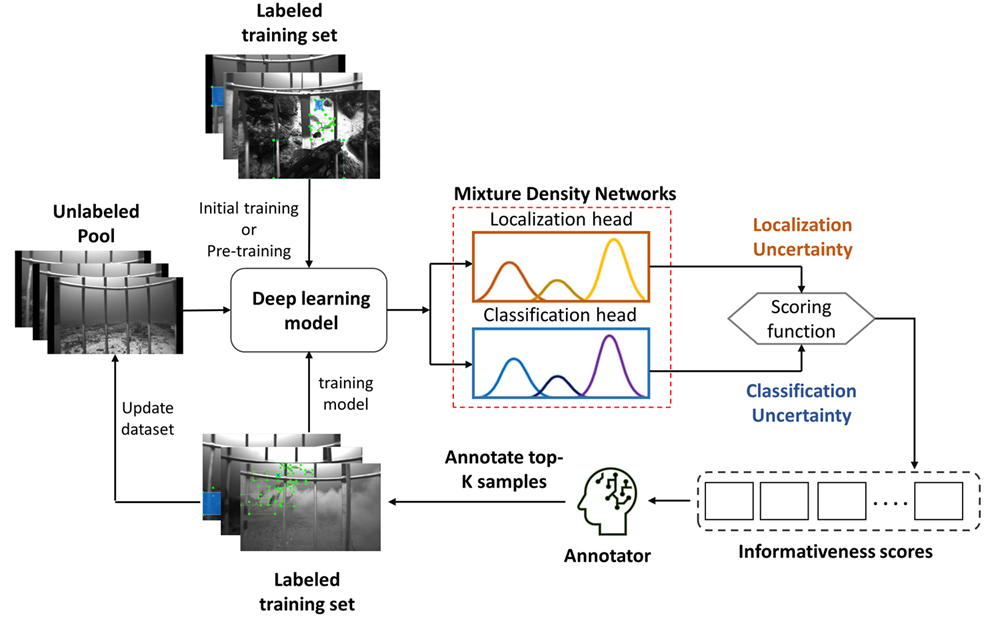

**Fig. 3. Overall architecture of deep active learning-based fish identification (adapted from Choi et al.)**

**This function initializes the training process by loading datasets, setting up loss functions, and training the model. It manages an active learning loop, where the best-performing weights are selected, and the labeled and unlabeled sets are updated based on the model’s performance. The training is repeated after updating the data loaders and saving the labeled dataset at each cycle**

In [ ]:
def main():
    if args.cuda:
        cudnn.benchmark = True
    #print(args)
    supervised_dataset, supervised_data_loader, unsupervised_dataset, unsupervised_data_loader, indices, labeled_set, unlabeled_set = create_loaders()
    criterion = MultiBoxLoss_GMM(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5, False, args.cuda)
    print('labeled_set', 'unlabeled_set')
    print(len(labeled_set), len(unlabeled_set))
    net = train(labeled_set, supervised_data_loader, indices, cfg, criterion)


    # # active learning loop
    for i in range(cfg['num_cycles']):
        if cfg['name'] == 'VOC':
            # select the best weight
            list_iter = ['300', '500']
            list_weights = []
            for loop in list_iter:
                name = 'weights/ssd300_AL_' + cfg['name'] + '_id_' + str(args.id) + '_num_labels_' + str(len(labeled_set)) + '_' + loop + '.pth'
                list_weights.append(str(name))

            list_mean = []
            for loop in list_weights:
                net = build_ssd_gmm('test', cfg['min_dim'], cfg['num_classes'])
                net = nn.DataParallel(net)
                print('loading trained weight {}...'.format(loop))
                net.load_state_dict(torch.load(loop))
                net.eval()
                test_dataset = VOCDetection(args.voc_root, [('2007', 'test')], BaseTransform(300, MEANS), VOCAnnotationTransform())
                mean_ap = test_net(args.eval_save_folder, net, args.cuda,
                                   test_dataset, BaseTransform(300, MEANS),
                                   args.top_k, 300, thresh=args.confidence_threshold)
                list_mean.append(float(mean_ap))
            best_weight = list_weights[list_mean.index(max(list_mean))]

            # active learning
            net = build_ssd_gmm('train', cfg['min_dim'], cfg['num_classes'])
            net = nn.DataParallel(net)
            print('loading best weight {}...'.format(best_weight))
            net.load_state_dict(torch.load(best_weight))

        net.eval()
        batch_iterator = iter(unsupervised_data_loader)
        labeled_set, unlabeled_set = active_learning_cycle(
            batch_iterator,
            labeled_set,
            unlabeled_set,
            net,
            cfg["num_classes"],
            acquisition_budget=cfg['acquisition_budget'],
            num_total_images=cfg['num_total_images'],
        )

        # save the labeled training set list
        f = open("labeled_training_set_" + cfg['name'] + '_' + str(len(labeled_set)) + '_id_' + str(args.id) + ".txt", 'w')
        for i in range(len(labeled_set)):
            f.write(str(labeled_set[i]))
            f.write("\n")
        f.close()

        # change the loaders
        supervised_data_loader, unsupervised_data_loader = change_loaders(supervised_dataset, unsupervised_dataset, labeled_set, unlabeled_set)
        print(len(labeled_set), len(unlabeled_set))

        args.resume = None
        args.start_iter = 0
        net = train(labeled_set, supervised_data_loader, indices, cfg, criterion)

if __name__ == '__main__':
    main()

labeled_set unlabeled_set
100 38
Loading base network...
Initializing weights...
timer: 0.3994 sec.
iter 0 || Loss: 34.1358 || loss: 34.1358 , loss_c: 24.9331 , loss_l: 9.2028 , lr : 0.0000

timer: 0.4131 sec.
iter 100 || Loss: 32.1508 || loss: 32.1508 , loss_c: 25.0799 , loss_l: 7.0710 , lr : 0.0000

timer: 0.4167 sec.
iter 200 || Loss: 34.9158 || loss: 34.9158 , loss_c: 25.0414 , loss_l: 9.8745 , lr : 0.0000

timer: 0.4394 sec.
iter 300 || Loss: 38.9748 || loss: 38.9748 , loss_c: 23.8190 , loss_l: 15.1559 , lr : 0.0005

timer: 0.2948 sec.
iter 400 || Loss: 26.9282 || loss: 26.9282 , loss_c: 21.8278 , loss_l: 5.1004 , lr : 0.0000

loading trained weight weights/ssd300_AL_VOC_id_1_num_labels_100_300.pth...


FileNotFoundError: [Errno 2] No such file or directory: 'weights/ssd300_AL_VOC_id_1_num_labels_100_300.pth'

**This part of the code applied the trained model on test image. For convinience, we utlized previously trained weights for the demostration purpose.**

In [ ]:
!python demo.py --trained_model weights/ssd300_AL_VOC_id_1_num_labels_110000_120000.pth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tensor(0.8962)
73.76077 385.5328 1047.4067 994.21356
----
tensor(0.9666)
1272.2244 664.69037 1598.694 830.23285
----


We applied our trained model on a test image and it is showing two detections approximately 90% and 97% detection accuracy. Besides that bounding box corrdinates are also generated.

**The prediction of the model is illustrated on a single test image.**

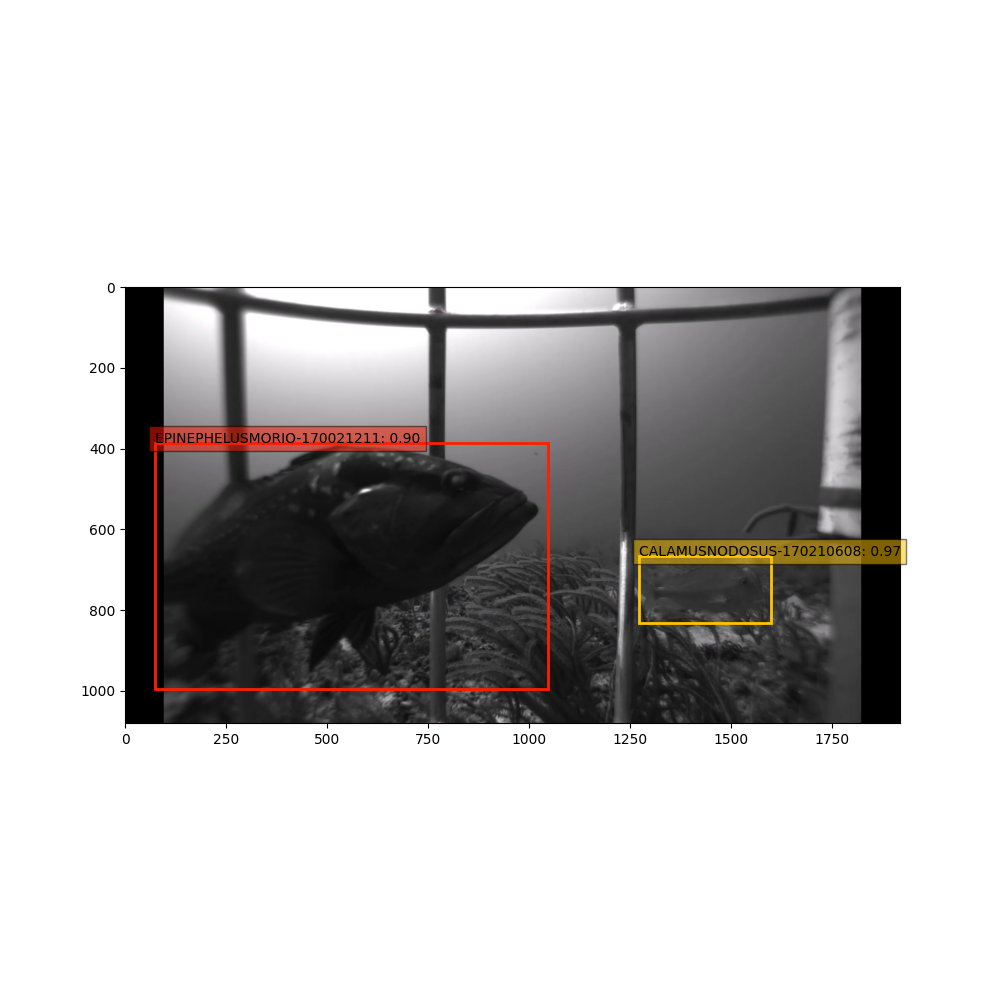

In [ ]:
from IPython.display import Image, display

# Display the saved image
display(Image(filename='out_img.png'))

**References**

```
This work is adapted from AL-MDN, and SSD.

If you find this work useful, please feel free to cite:

@inproceedings{nabi2023probabilistic,
  title={Probabilistic Model-Based Active Learning with Attention Mechanism for Fish Species Recognition},
  author={Nabi, MM and Shah, Chiranjibi and Alaba, Simegnew Yihunie and Prior, Jack and Campbell, Matthew D and Wallace, Farron and Moorhead, Robert and Ball, John E},
  booktitle={OCEANS 2023-MTS/IEEE US Gulf Coast},
  pages={1--8},
  year={2023},
  organization={IEEE}
}
```